# Binary Adapter Annotation Inspection

Visual comparison of how the multi-class `Adapter` and binary `BinaryAdapter` process ARCADE annotations.

For each sample image we show:
1. **Raw ARCADE annotations** — original category IDs, bounding boxes, segmentation polygons
2. **Multi-class Adapter output** — remapped category IDs (0-indexed), per-instance annotations
3. **Binary Adapter output** — all instances collapsed to `category_id=0` ("vessel")

In [1]:
import json
import os
import sys

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.collections import PatchCollection

# Make project importable
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from coro_dt.data.adapter import Adapter
from coro_dt.data.binary_adapter import BinaryAdapter

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [2]:
ARCADE_ROOT = '/Users/piotrswiecik/dev/ives/coronary/datasets/arcade/syntax'
SPLIT = 'train'

json_path = os.path.join(ARCADE_ROOT, SPLIT, 'annotations', f'{SPLIT}.json')
img_dir = os.path.join(ARCADE_ROOT, SPLIT, 'images')

with open(json_path) as f:
    raw_data = json.load(f)

print(f'Images: {len(raw_data["images"])}')
print(f'Annotations: {len(raw_data["annotations"])}')
print(f'Categories: {[c["id"] for c in raw_data["categories"]]}')

Images: 1000
Annotations: 4976
Categories: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [3]:
multi_adapter = Adapter(raw_data, img_dir)
binary_adapter = BinaryAdapter(raw_data, img_dir)

multi_records = multi_adapter.as_list()
binary_records = binary_adapter.as_list()

print(f'Multi-class: {len(multi_records)} images, classes={multi_adapter.class_names[:5]}... ({len(multi_adapter.class_names)} total)')
print(f'Binary:      {len(binary_records)} images, classes={binary_adapter.class_names}')
print(f'Multi id_map (first 5): {dict(list(multi_adapter.id_map.items())[:5])}')
print(f'Binary id_map: {binary_adapter.id_map}')

Multi-class: 1000 images, classes=['category_1', 'category_2', 'category_3', 'category_4', 'category_5']... (25 total)
Binary:      1000 images, classes=['vessel']
Multi id_map (first 5): {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
Binary id_map: {0: 0}


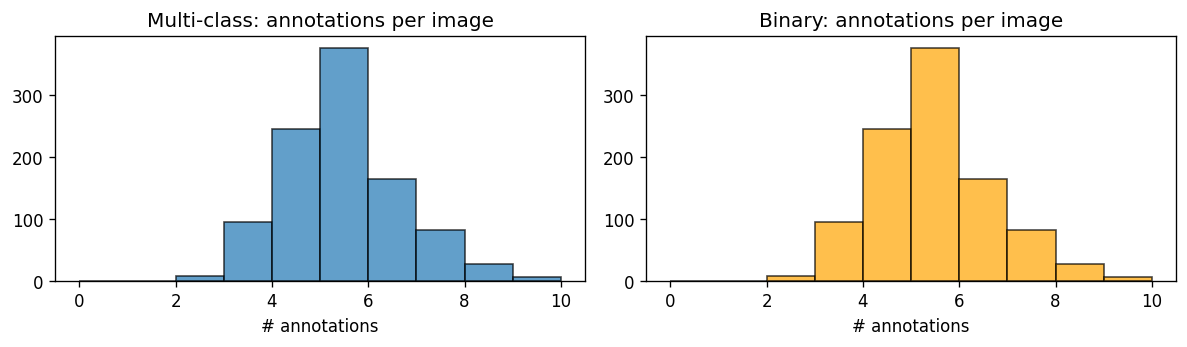

Multi  — min: 2, max: 9, mean: 5.0
Binary — min: 2, max: 9, mean: 5.0


In [4]:
multi_ann_counts = [len(r['annotations']) for r in multi_records]
binary_ann_counts = [len(r['annotations']) for r in binary_records]

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(multi_ann_counts, bins=range(0, max(multi_ann_counts) + 2), edgecolor='black', alpha=0.7)
axes[0].set_title('Multi-class: annotations per image')
axes[0].set_xlabel('# annotations')

axes[1].hist(binary_ann_counts, bins=range(0, max(binary_ann_counts) + 2), edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Binary: annotations per image')
axes[1].set_xlabel('# annotations')

plt.tight_layout()
plt.show()

print(f'Multi  — min: {min(multi_ann_counts)}, max: {max(multi_ann_counts)}, mean: {np.mean(multi_ann_counts):.1f}')
print(f'Binary — min: {min(binary_ann_counts)}, max: {max(binary_ann_counts)}, mean: {np.mean(binary_ann_counts):.1f}')
assert multi_ann_counts == binary_ann_counts, 'Annotation counts should be identical (same instances, different category_id)'

In [5]:
COLORS = plt.cm.tab20.colors


def plot_annotations(ax, img_bgr, annotations, title, color_by_category=True):
    """Draw bboxes and segmentation polygons on an image."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

    for ann in annotations:
        cat = ann['category_id']
        color = COLORS[cat % len(COLORS)] if color_by_category else (1.0, 0.3, 0.1)

        # bbox (XYXY_ABS)
        x1, y1, x2, y2 = ann['bbox']
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=1.5, edgecolor=color, facecolor='none', linestyle='--'
        )
        ax.add_patch(rect)

        # label
        ax.text(x1, y1 - 2, f'cat={cat}', fontsize=6, color=color,
                bbox=dict(facecolor='black', alpha=0.5, pad=1, edgecolor='none'))

        # segmentation polygons
        for seg in ann.get('segmentation', []):
            pts = np.array(seg).reshape(-1, 2)
            poly = patches.Polygon(pts, closed=True, linewidth=1.2,
                                   edgecolor=color, facecolor=(*color[:3], 0.15))
            ax.add_patch(poly)

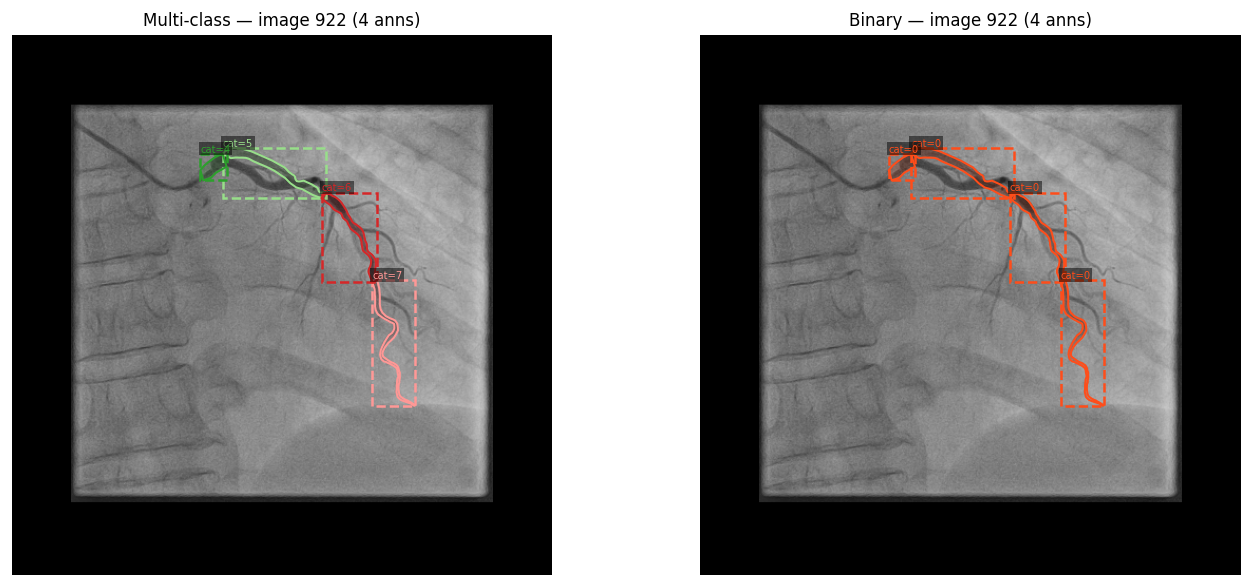

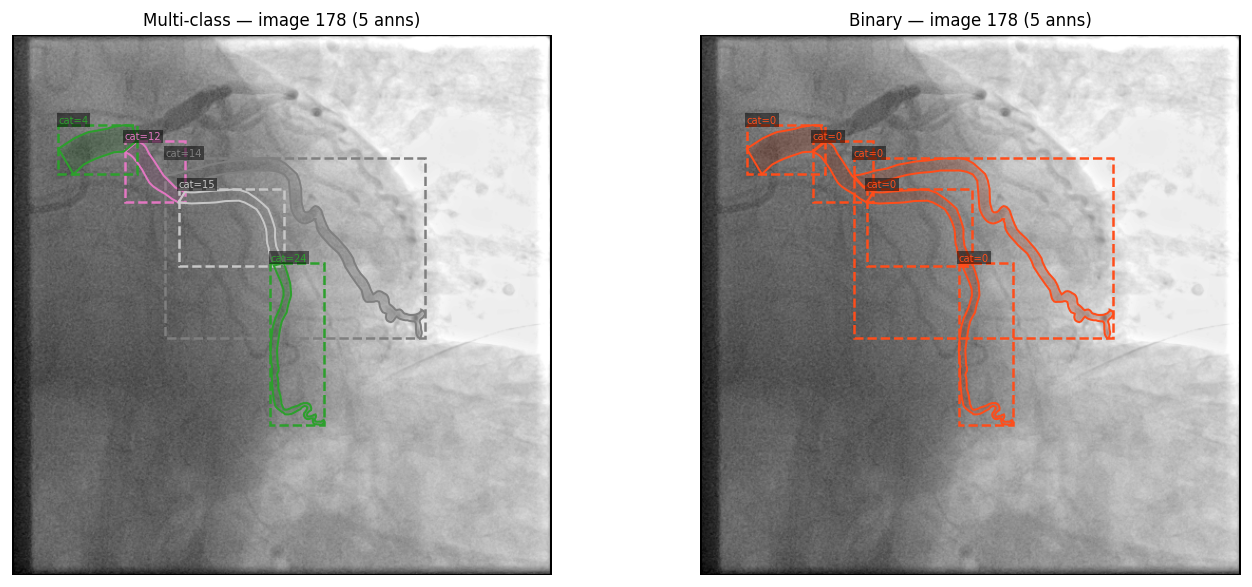

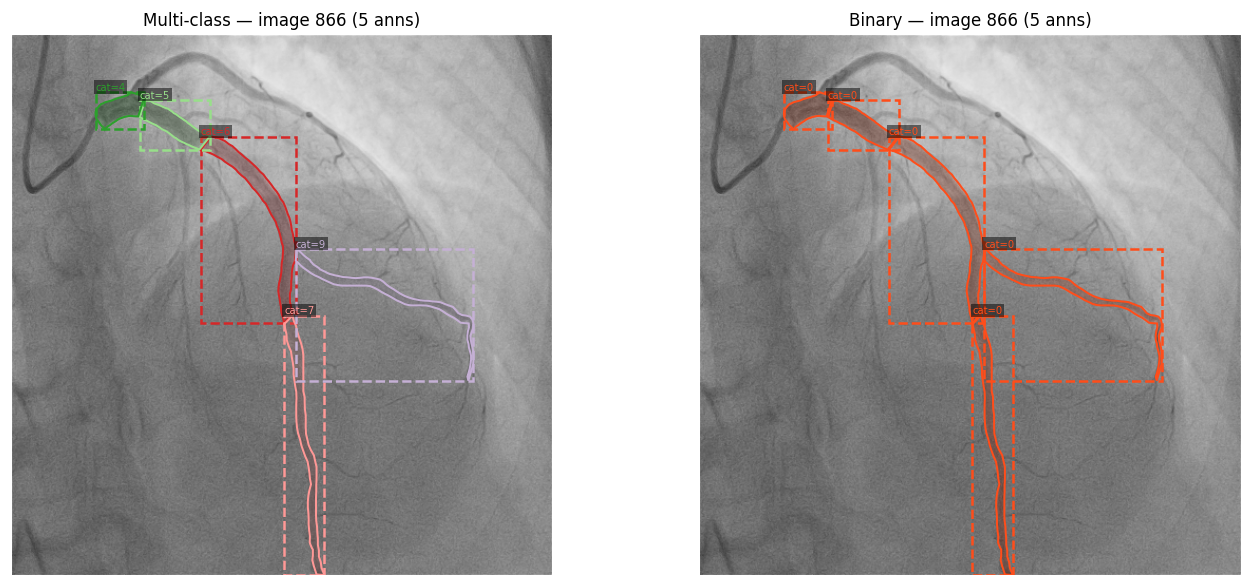

In [6]:
# Pick sample images — first, middle, last
indices = [0, len(multi_records) // 2, len(multi_records) - 1]

for idx in indices:
    mr = multi_records[idx]
    br = binary_records[idx]

    img = cv2.imread(mr['file_name'])
    if img is None:
        print(f'Could not read {mr["file_name"]}, skipping')
        continue

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_annotations(ax1, img, mr['annotations'],
                     f'Multi-class — image {mr["image_id"]} ({len(mr["annotations"])} anns)',
                     color_by_category=True)
    plot_annotations(ax2, img, br['annotations'],
                     f'Binary — image {br["image_id"]} ({len(br["annotations"])} anns)',
                     color_by_category=False)

    plt.tight_layout()
    plt.show()

## Per-annotation detail

Print the raw annotation dicts side-by-side for a single image to verify field-level correctness.

In [7]:
sample_idx = 0
mr = multi_records[sample_idx]
br = binary_records[sample_idx]

print(f'Image: {mr["image_id"]}  ({mr["width"]}x{mr["height"]})')
print(f'File:  {mr["file_name"]}')
print(f'Annotations: multi={len(mr["annotations"])}, binary={len(br["annotations"])}\n')

for i, (ma, ba) in enumerate(zip(mr['annotations'], br['annotations'])):
    print(f'--- annotation {i} ---')
    print(f'  multi  category_id={ma["category_id"]:>2d}  bbox={[round(v,1) for v in ma["bbox"]]}  seg_polygons={len(ma["segmentation"])}  seg_points={sum(len(s)//2 for s in ma["segmentation"])}')
    print(f'  binary category_id={ba["category_id"]:>2d}  bbox={[round(v,1) for v in ba["bbox"]]}  seg_polygons={len(ba["segmentation"])}  seg_points={sum(len(s)//2 for s in ba["segmentation"])}')
    assert ba['category_id'] == 0, f'Binary category_id should be 0, got {ba["category_id"]}'
    assert ma['bbox'] == ba['bbox'], f'Bboxes should match: {ma["bbox"]} vs {ba["bbox"]}'
    assert ma['segmentation'] == ba['segmentation'], 'Segmentations should match'

print('\nAll assertions passed — annotations are identical except category_id.')

Image: 922  (512x512)
File:  /Users/piotrswiecik/dev/ives/coronary/datasets/arcade/syntax/train/images/922.png
Annotations: multi=4, binary=4

--- annotation 0 ---
  multi  category_id= 7  bbox=[341.0, 232.0, 382.0, 351.0]  seg_polygons=1  seg_points=120
  binary category_id= 0  bbox=[341.0, 232.0, 382.0, 351.0]  seg_polygons=1  seg_points=120
--- annotation 1 ---
  multi  category_id= 5  bbox=[199.2, 106.8, 297.2, 153.9]  seg_polygons=1  seg_points=56
  binary category_id= 0  bbox=[199.2, 106.8, 297.2, 153.9]  seg_polygons=1  seg_points=56
--- annotation 2 ---
  multi  category_id= 4  bbox=[178.1, 112.0, 203.0, 137.2]  seg_polygons=1  seg_points=11
  binary category_id= 0  bbox=[178.1, 112.0, 203.0, 137.2]  seg_polygons=1  seg_points=11
--- annotation 3 ---
  multi  category_id= 6  bbox=[293.0, 148.9, 345.5, 234.0]  seg_polygons=1  seg_points=121
  binary category_id= 0  bbox=[293.0, 148.9, 345.5, 234.0]  seg_polygons=1  seg_points=121

All assertions passed — annotations are identica

## Bounding box size distribution

Verify that individual bboxes are reasonably sized (not image-spanning).

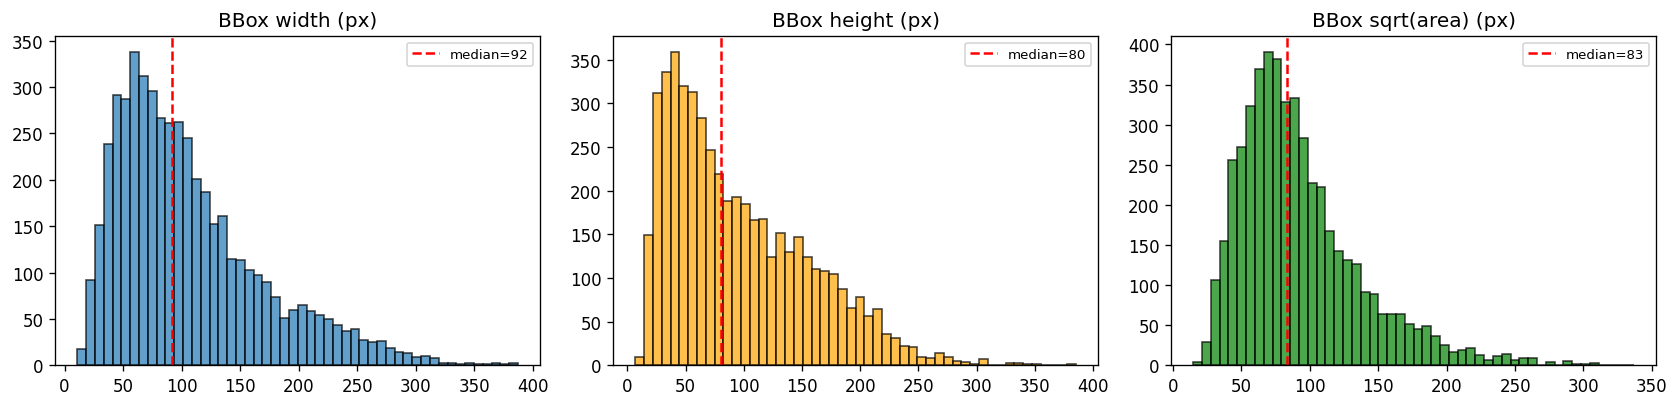

Total annotations: 4976
Width  — min: 11, max: 388, median: 92
Height — min: 7, max: 385, median: 80


In [8]:
widths, heights, areas = [], [], []
for r in binary_records:
    for ann in r['annotations']:
        x1, y1, x2, y2 = ann['bbox']
        w, h = x2 - x1, y2 - y1
        widths.append(w)
        heights.append(h)
        areas.append(w * h)

fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

axes[0].hist(widths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('BBox width (px)')
axes[0].axvline(np.median(widths), color='red', ls='--', label=f'median={np.median(widths):.0f}')
axes[0].legend(fontsize=8)

axes[1].hist(heights, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('BBox height (px)')
axes[1].axvline(np.median(heights), color='red', ls='--', label=f'median={np.median(heights):.0f}')
axes[1].legend(fontsize=8)

axes[2].hist(np.sqrt(areas), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_title('BBox sqrt(area) (px)')
axes[2].axvline(np.median(np.sqrt(areas)), color='red', ls='--', label=f'median={np.median(np.sqrt(areas)):.0f}')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f'Total annotations: {len(widths)}')
print(f'Width  — min: {min(widths):.0f}, max: {max(widths):.0f}, median: {np.median(widths):.0f}')
print(f'Height — min: {min(heights):.0f}, max: {max(heights):.0f}, median: {np.median(heights):.0f}')

## Browse any image

Change `IMAGE_IDX` to inspect a specific image.

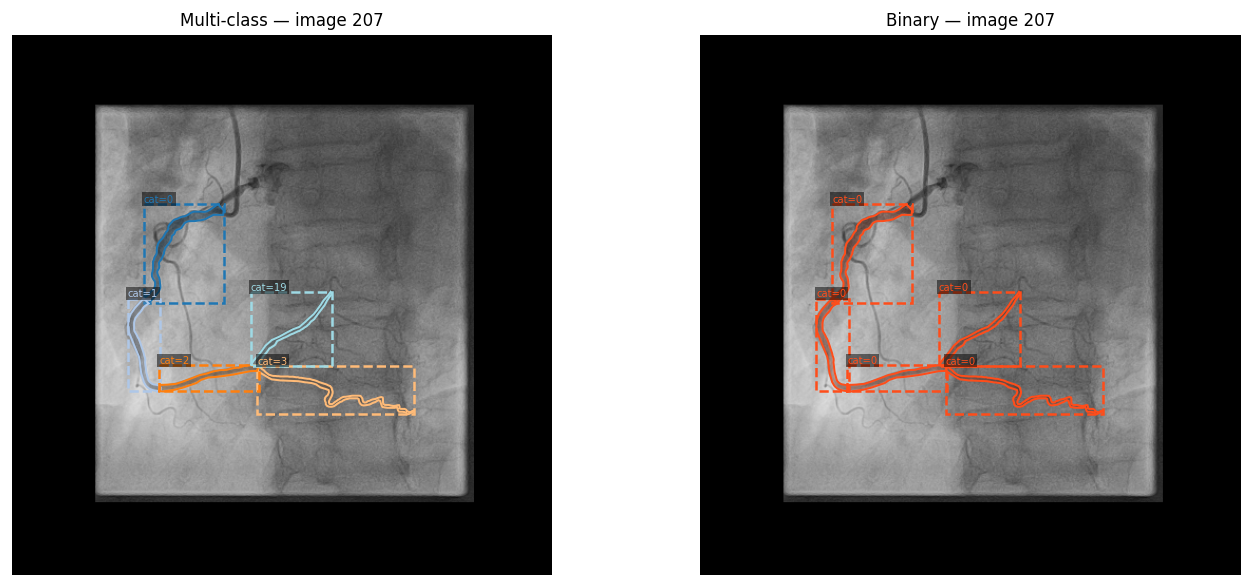

  [0] cat=0  bbox=[232,313,381,359]  size=149x46
  [1] cat=0  bbox=[124,160,200,254]  size=76x94
  [2] cat=0  bbox=[109,249,140,338]  size=31x88
  [3] cat=0  bbox=[139,313,233,338]  size=94x25
  [4] cat=0  bbox=[226,243,303,313]  size=77x70


In [9]:
IMAGE_IDX = 5  # <-- change this

mr = multi_records[IMAGE_IDX]
br = binary_records[IMAGE_IDX]
img = cv2.imread(mr['file_name'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_annotations(ax1, img, mr['annotations'],
                 f'Multi-class — image {mr["image_id"]}', color_by_category=True)
plot_annotations(ax2, img, br['annotations'],
                 f'Binary — image {br["image_id"]}', color_by_category=False)
plt.tight_layout()
plt.show()

for i, ann in enumerate(br['annotations']):
    x1, y1, x2, y2 = ann['bbox']
    print(f'  [{i}] cat={ann["category_id"]}  bbox=[{x1:.0f},{y1:.0f},{x2:.0f},{y2:.0f}]  size={x2-x1:.0f}x{y2-y1:.0f}')